SARIMAX

C:\Users\Sathvik\AppData\Local\Temp\ipykernel_22108\2866858441.py:14: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  df["date"] = pd.PeriodIndex(year=df["year"], month=df["month"], freq="M")
C:\Users\Sathvik\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Average Sea Ice Area in 2024 (forecast): 9.471 million km²

Monthly Forecast for 2024:
          date      value  year  month
543 2024-01-01  12.498493  2024      1
544 2024-02-01  13.402788  2024      2
545 2024-03-01  13.582822  2024      3
546 2024-04-01  13.011905  2024      4
547 2024-05-01  11.658943  2024      5
548 2024-06-01   9.294590  2024      6
549 2024-07-01   6.727863  2024      7
550 2024-08-01   4.355569  2024      8
551 2024-09-01   3.643252  2024      9
552 2024-10-01   5.674173  2024     10
553 2024-11-01   8.811558  2024     11
554 2024-12-01  10.985905  2024     12

First ice-free September predicted in: 2042-09


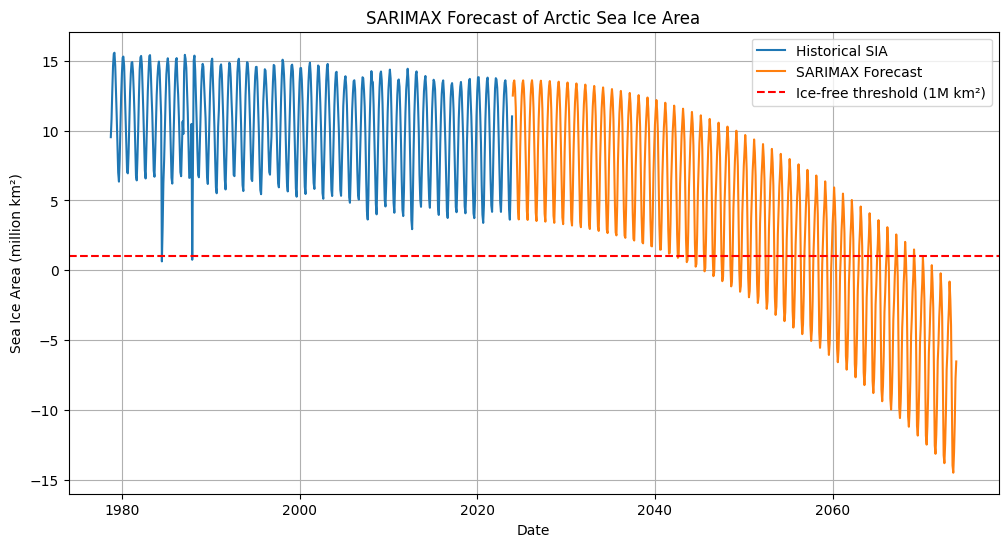

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.statespace.sarimax import SARIMAX

# === Load Data ===
BASE_DIR = Path().resolve().parents[1]
file_PATH_arctic = BASE_DIR / "data" / "processed" / "final_arctic.csv"
df = pd.read_csv(file_PATH_arctic)
df = df.sort_values(["year", "month"])

# Use PeriodIndex for monthly data (no artificial day=1)
df["date"] = pd.PeriodIndex(year=df["year"], month=df["month"], freq="M")

# Target & exogenous features
y = df["sia_million_km2"]
X_exog = df.drop(columns=["sia_million_km2", "year", "month", "date"]) \
           .replace([np.inf, -np.inf], np.nan).ffill().bfill()

# === Train on entire dataset ===
sarimax_model = SARIMAX(y, exog=X_exog,
                        order=(0, 1, 0), seasonal_order=(2, 2, 0, 12))
sarimax_res = sarimax_model.fit(disp=False)

# === Forecast far ahead ===
n_years_forecast = 50
future_periods = pd.period_range(start=df["date"].iloc[-1] + 1, periods=n_years_forecast * 12, freq="M")
future_exog = pd.DataFrame(
    np.tile(X_exog.iloc[-12:].values, (n_years_forecast, 1)),
    columns=X_exog.columns
)
forecast = sarimax_res.get_forecast(steps=len(future_periods), exog=future_exog)
forecast_mean = forecast.predicted_mean

forecast_df = pd.DataFrame({"date": future_periods.to_timestamp(), "value": forecast_mean})
forecast_df["year"] = forecast_df["date"].dt.year
forecast_df["month"] = forecast_df["date"].dt.month

# === 2024 Predictions ===
avg_2024 = forecast_df.loc[forecast_df["year"] == 2024, "value"].mean()
print(f"\nAverage Sea Ice Area in 2024 (forecast): {avg_2024:.3f} million km²")

print("\nMonthly Forecast for 2024:")
print(forecast_df[forecast_df["year"] == 2024])

# === Detect first ice-free September (< 1 million km²) ===
ice_free_year = forecast_df[(forecast_df["month"] == 9) & (forecast_df["value"] < 1)].head(1)
if not ice_free_year.empty:
    print(f"\nFirst ice-free September predicted in: {ice_free_year.iloc[0]['date'].strftime('%Y-%m')}")
else:
    print("\nNo ice-free September within forecast horizon.")

# === Plot forecast ===
plt.figure(figsize=(12,6))
plt.plot(df["date"].dt.to_timestamp(), y, label="Historical SIA")
plt.plot(forecast_df["date"], forecast_df["value"], label="SARIMAX Forecast")
plt.axhline(1, color="red", linestyle="--", label="Ice-free threshold (1M km²)")
plt.xlabel("Date")
plt.ylabel("Sea Ice Area (million km²)")
plt.title("SARIMAX Forecast of Arctic Sea Ice Area")
plt.legend()
plt.grid(True)
plt.show()



In [10]:
import pandas as pd
import numpy as np
from pathlib import Path
from statsmodels.tsa.statespace.sarimax import SARIMAX

# === Load Data ===
BASE_DIR = Path().resolve().parents[1]
file_PATH_arctic = BASE_DIR / "data" / "processed" / "final_arctic.csv"
df = pd.read_csv(file_PATH_arctic)
df = df.sort_values(["year", "month"])

# Use PeriodIndex for monthly data
df["date"] = pd.PeriodIndex(year=df["year"], month=df["month"], freq="M")

# Target & exogenous features
y = df["sia_million_km2"]
X_exog = df.drop(columns=["sia_million_km2", "year", "month", "date"]) \
           .replace([np.inf, -np.inf], np.nan).ffill().bfill()

# === Train SARIMAX ===
sarimax_model = SARIMAX(y, exog=X_exog,
                        order=(0, 1, 0), seasonal_order=(2, 2, 0, 12))
sarimax_res = sarimax_model.fit(disp=False)

# === Forecast ===
n_years_forecast = 50
future_periods = pd.period_range(start=df["date"].iloc[-1] + 1, periods=n_years_forecast * 12, freq="M")
future_exog = pd.DataFrame(
    np.tile(X_exog.iloc[-12:].values, (n_years_forecast, 1)),
    columns=X_exog.columns
)
forecast = sarimax_res.get_forecast(steps=len(future_periods), exog=future_exog)
forecast_ci = forecast.conf_int(alpha=0.05)
forecast_df = pd.DataFrame({
    "date": future_periods.to_timestamp(),
    "forecast": forecast.predicted_mean,
    "lower_95": forecast_ci.iloc[:, 0],
    "upper_95": forecast_ci.iloc[:, 1]
})
forecast_df["year"] = forecast_df["date"].dt.year
forecast_df["month"] = forecast_df["date"].dt.month

# === 2024 Predictions ===
avg_2024 = forecast_df.loc[forecast_df["year"] == 2024, "forecast"].mean()
print(f"\nAverage Sea Ice Area in 2024 (forecast): {avg_2024:.3f} million km²")

print("\nMonthly Forecast for 2024 with 95% CI:")
forecast_2024 = forecast_df[forecast_df["year"] == 2024][
    ["year", "month", "forecast", "lower_95", "upper_95"]
].reset_index(drop=True)

print(forecast_2024.to_string(index=False))

# === First ice-free September (central estimate) ===
ice_free_year = forecast_df[
    (forecast_df["month"] == 9) &
    (forecast_df["forecast"] < 1)
].head(1)

# === Earliest possible ice-free September (lower bound < 1) ===
earliest_possible = forecast_df[
    (forecast_df["month"] == 9) &
    (forecast_df["lower_95"] < 1)
].head(1)

# === Latest possible ice-free September (upper bound < 1) ===
latest_possible = forecast_df[
    (forecast_df["month"] == 9) &
    (forecast_df["upper_95"] < 1)
].head(1)

if not ice_free_year.empty:
    central_date = ice_free_year.iloc[0]["date"]
    earliest_date = earliest_possible.iloc[0]["date"] if not earliest_possible.empty else None
    latest_date = latest_possible.iloc[0]["date"] if not latest_possible.empty else None
    
    print(f"\nFirst ice-free September predicted in: {central_date.strftime('%Y-%m')}")
    if earliest_date and latest_date:
        print(f"95% CI for first ice-free September: {earliest_date.strftime('%Y-%m')} to {latest_date.strftime('%Y-%m')}")
else:
    print("\nNo ice-free September within forecast horizon.")


C:\Users\Sathvik\AppData\Local\Temp\ipykernel_22108\4247445070.py:13: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  df["date"] = pd.PeriodIndex(year=df["year"], month=df["month"], freq="M")
C:\Users\Sathvik\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Average Sea Ice Area in 2024 (forecast): 9.471 million km²

Monthly Forecast for 2024 with 95% CI:
 year  month  forecast  lower_95  upper_95
 2024      1 12.498493 12.239222 12.757763
 2024      2 13.402788 13.036125 13.769452
 2024      3 13.582822 13.133752 14.031891
 2024      4 13.011905 12.493365 13.530446
 2024      5 11.658943 11.079197 12.238690
 2024      6  9.294590  8.659509  9.929670
 2024      7  6.727863  6.041898  7.413828
 2024      8  4.355569  3.622241  5.088896
 2024      9  3.643252  2.865441  4.421064
 2024     10  5.674173  4.854288  6.494058
 2024     11  8.811558  7.951656  9.671461
 2024     12 10.985905 10.087766 11.884044

First ice-free September predicted in: 2042-09
